Name: Faiza Tasnim
ID: 19-41552-3
Sec: C

**Connect with Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import dataset from drive and unzip it**

In [31]:
from zipfile import ZipFile
with ZipFile ('/content/drive/MyDrive/Face Mask Dataset.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/content/datasets')

**Import libraries from Tensorflow**

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

**Import libraries from Sklearn**

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

**Import other libraries**

In [34]:
import glob as gb
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Resize and link the dataset**

In [35]:
resize = 224
learning_rate = 1e-4
seed = 107
INIT_LR = 1e-4
EPOCHS = 8
BS = 64

dir_mask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithMask'
dir_inc_mask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/incorrect_mask'
dir_nomask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithoutMask'
TRAIN_DIR = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train'

assert os.path.exists(dir_mask), 'Could not find' + dir_mask
assert os.path.exists(dir_inc_mask), 'Could not find' + dir_inc_mask
assert os.path.exists(dir_nomask), 'Could not find' + dir_nomask

**Show the graph of the catagories**

100%|██████████| 3/3 [00:00<00:00, 39.92it/s]


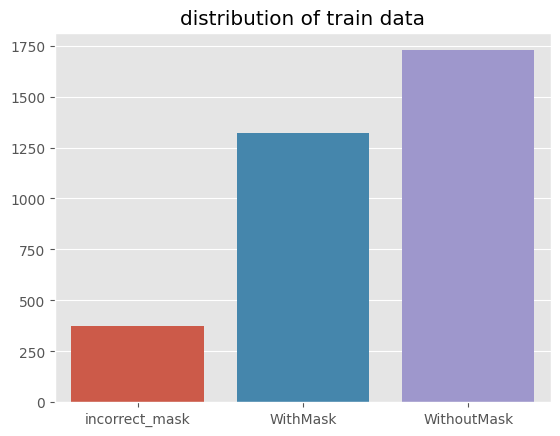

3424


100%|██████████| 1728/1728 [00:05<00:00, 328.70it/s]


In [36]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

CATEGORIES = ["with_mask", "mask_weared_incorrect", "without_mask"]
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data= np.array(data, dtype="float32")
labels = np.array(labels)

**See the labels**

In [37]:
len(labels)

3424

**Count of the catagories**

In [38]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'WithMask': 1320, 'WithoutMask': 1728, 'incorrect_mask': 376}

**Show the array**

In [39]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [40]:
AugmentedData = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    )

**Show the With mask image**

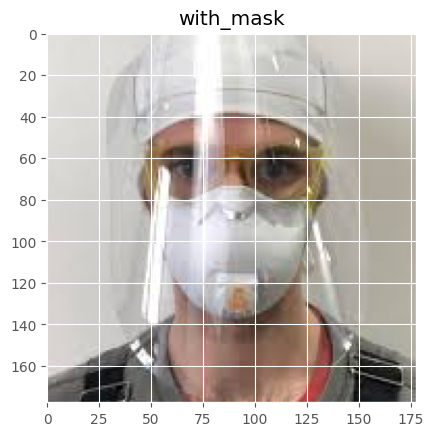

In [41]:
image1 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithMask/1021.png')
plt.figure('image1')
plt.title("with_mask")
plt.imshow(image1)

**Show the inccorect mask image**

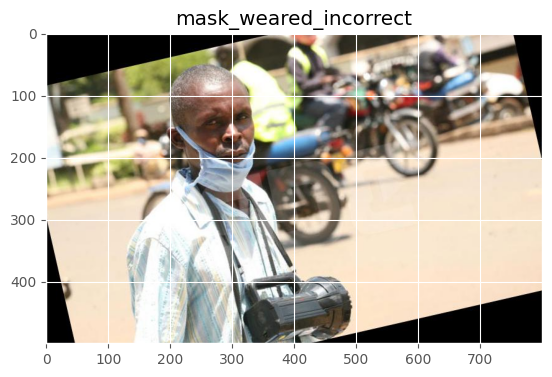

In [42]:
image2 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/incorrect_mask/aug_100.jpg')
plt.figure('image2')
plt.title("mask_weared_incorrect")
plt.imshow(image2)

**Show the Without mask image**

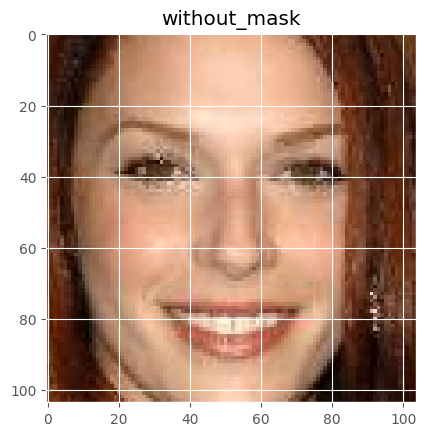

In [43]:
image3 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithoutMask/1004.png')
plt.figure('image3')
plt.title("without_mask")
plt.imshow(image3)

**Shape of train and test dataset**

In [44]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.2, stratify=labels, random_state=42)

print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (2739, 224, 224, 3)
Shape of y_train: (2739, 3)

Shape of x_test: (685, 224, 224, 3)
Shape of y_test: (685, 3)


**Use MobileNetV2 model**

In [45]:
baseModel = MobileNetV2(input_shape= [224,224,3], weights='imagenet', include_top=False)
baseModel.summary()
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Compile the model and execute 8 epoch**



In [46]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("""[INFO] compiling model...
[INFO] training head...""")
H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/8
42/42 [==============================] - 50s 988ms/step - loss: 0.4615 - accuracy: 0.8247 - val_loss: 0.1601 - val_accuracy: 0.9460
Epoch 2/8
42/42 [==============================] - 33s 782ms/step - loss: 0.1424 - accuracy: 0.9581 - val_loss: 0.1089 - val_accuracy: 0.9606
Epoch 3/8
42/42 [==============================] - 32s 753ms/step - loss: 0.0980 - accuracy: 0.9679 - val_loss: 0.0832 - val_accuracy: 0.9737
Epoch 4/8
42/42 [==============================] - 33s 791ms/step - loss: 0.0766 - accuracy: 0.9768 - val_loss: 0.0727 - val_accuracy: 0.9781
Epoch 5/8
42/42 [==============================] - 33s 776ms/step - loss: 0.0590 - accuracy: 0.9836 - val_loss: 0.0572 - val_accuracy: 0.9810
Epoch 6/8
42/42 [==============================] - 31s 750ms/step - loss: 0.0528 - accuracy: 0.9828 - val_loss: 0.0515 - val_accuracy: 0.9825
Epoch 7/8
42/42 [==============================] - 32s 760ms/step - loss: 0.0459 - accuracy: 0.985

In [47]:
model.save("mask_detector.model", save_format="h5")

**Show the train and validation loss and accuracy graph**

[INFO] evaluating network...
11/11 [==============================] - 2s 86ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       264
           1       1.00      0.99      0.99       346
           2       0.99      0.93      0.96        75

    accuracy                           0.98       685
   macro avg       0.98      0.97      0.98       685
weighted avg       0.98      0.98      0.98       685



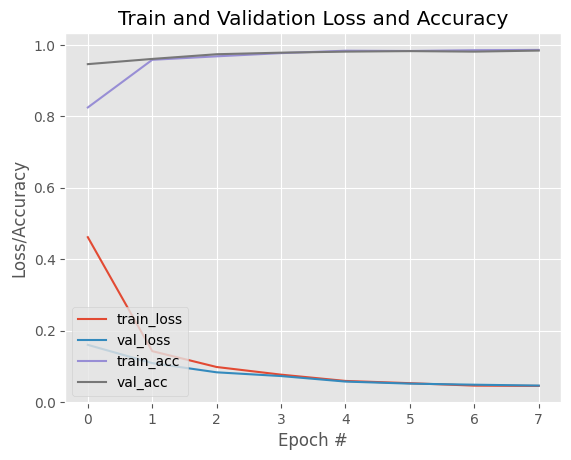

In [48]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs
	))
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Train and Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()